## Quark-Gluon Dataset Compression ## 
This preprocesses the data and creates a new, smaller QG dataset of the chosen size.

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import h5py

In [15]:
f = h5py.File("../data/quark-gluon_train-set_n793900.hdf5", "r")

In [16]:
x_train = f.get('X_jets')
y_train = f.get('y')

In [42]:
size = 16
Nvals = 2
Nsamples = 10000
QG_channel = 1 # 1st channel is 1
file_name = f"../data/QG{QG_channel}_normalized_{size}x{size}_100k"
# file_name = f"../data/QG{QG_channel}_{size}x{size}_1k"

In [31]:
def discretize_img(img):
    bins = np.linspace(0,1,Nvals+1)
    vals = np.linspace(0,1,Nvals)
    inds = np.digitize(img, bins)
    return vals[inds-1]

def crop_and_resize(x, channel, scale, crop_fraction=0.8):
    crop_size = int(125 * crop_fraction)
    start = (125 - crop_size) // 2
    end = start + crop_size
    channel_data = x[:, :, :, channel]
    cropped = channel_data[:, start:end, start:end]
    
    resized = np.zeros((x.shape[0], scale, scale), dtype=channel_data.dtype)
    for i in range(x.shape[0]):
        resized[i] = np.array(
            [[cropped[i, int(y * crop_size / scale), int(x * crop_size / scale)] 
              for x in range(scale)] 
             for y in range(scale)]
        )
    
    return resized[..., np.newaxis]

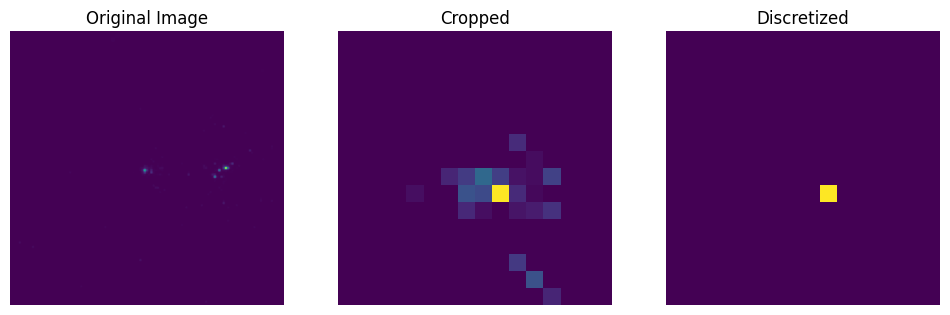

In [37]:
sample_idx = 19
original_image = x_train[sample_idx]

original_image = x_train[sample_idx]
cropped_resized_image = crop_and_resize(x_train[sample_idx:sample_idx+1], channel=QG_channel, scale=size, crop_fraction=0.2)[0, :, :, 0]

div1 = np.max(cropped_resized_image)
if div1 == 0:
    div1 = 1
cropped_resized_image_normalized = cropped_resized_image / (div1 + 0.00001)

discretized_image = discretize_img(cropped_resized_image_normalized)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(original_image[:, :, QG_channel])
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(cropped_resized_image)
axs[1].set_title("Cropped")
axs[1].axis('off')

axs[2].imshow(discretized_image)
axs[2].set_title("Discretized")
axs[2].axis('off')

plt.show()

In [20]:
'''
This is a test of non normalized or discretized images. 
'''
size = 16
Nvals = 2
Nsamples = 1000
QG_channel = 1 # 1st channel is 1

channel = QG_channel - 1 # 1st channel is 0
batch_size = 250
num_batches = Nsamples//batch_size

events = Nsamples
file_name = f"../data/QG{QG_channel}_{size}x{size}_{Nsamples//1000}k"
fnew = h5py.File(file_name, "w")

dsetx = fnew.create_dataset("X", (Nsamples, size, size), dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')

for i in range(num_batches):
    x = x_train[i * batch_size: (i + 1) * batch_size]
    y = y_train[i * batch_size: (i + 1) * batch_size]
    
    x_train_small = crop_and_resize(x, channel, size, crop_fraction=0.7)
    
    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x_train_small.reshape((x_train_small.shape[0], size, size))
    
    print(f"Batch {i+1}/{num_batches} processed", end="\r")

fnew.close()


Save a new file for the desired channel of a cropped size.

In [78]:
channel = QG_channel - 1 # 1st channel is 0
batch_size = 500
num_batches = Nsamples//batch_size

events = Nsamples

fnew = h5py.File(file_name, "w")

dsetx = fnew.create_dataset("X", (events,size,size), dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')

for i in range(num_batches):
    x = x_train[i * batch_size: (i + 1) * batch_size]
    y = y_train[i * batch_size: (i + 1) * batch_size]

    x_train_small = crop_and_resize(x, channel, size, crop_fraction=0.7)
    print(x_train_small)

    div1 = np.max(x_train_small, axis=(1,2)).reshape((batch_size,1,1,1))
    div1[div1 == 0] = 1
    x_train_small = x_train_small / (div1+0.00001)

    x_discr = discretize_img(x_train_small)

    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x_discr.reshape((x_discr.shape[0], size, size))
    print("batch ",i,"/",num_batches, end="\r")


[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.00904813]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0. 

In [79]:
fnew.close()

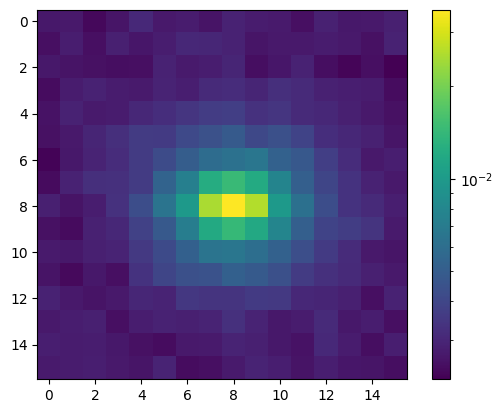

In [43]:
ftest = h5py.File(file_name,"r")

plt.imshow(np.mean(ftest['X'], axis=0), norm=matplotlib.colors.LogNorm())
plt.colorbar()

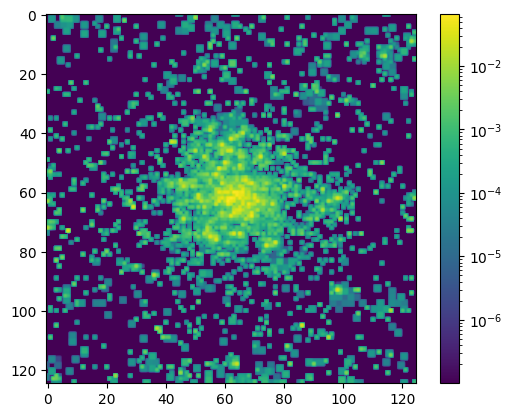

In [15]:
div1 = np.max(x_train[:30,:,:,1], axis=(1,2)).reshape((30,1,1))
div1[div1 == 0] = 1

plt.imshow(np.mean(x_train[:30,:,:,1]/div1+0.0000001,axis=0),norm=matplotlib.colors.LogNorm())
plt.colorbar()

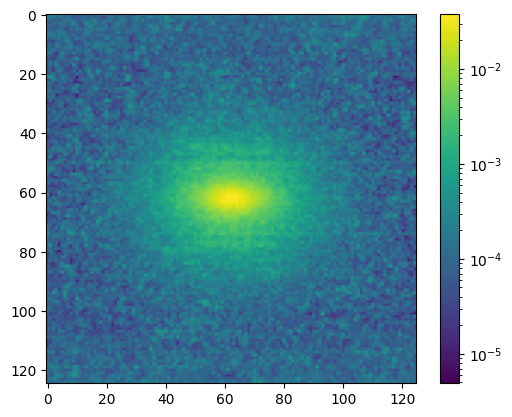

In [82]:
div1 = np.max(x_train[:3000,:,:,1], axis=(1,2)).reshape((3000,1,1))
div1[div1 == 0] = 1

plt.imshow(np.mean(x_train[:3000,:,:,1]/div1+0.0000001,axis=0),norm=matplotlib.colors.LogNorm())
plt.colorbar()

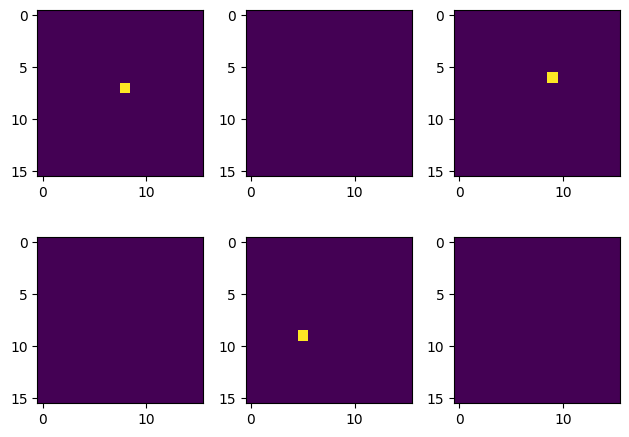

In [29]:
fig, ax = plt.subplots(2, 3)
nums = np.random.randint(0,Nsamples,size=(16,))
ax[0,0].imshow(ftest['X'][nums[0]])
ax[0,1].imshow(ftest['X'][nums[1]])
ax[0,2].imshow(ftest['X'][nums[2]])
ax[1,0].imshow(ftest['X'][nums[3]])
ax[1,1].imshow(ftest['X'][nums[4]])
ax[1,2].imshow(ftest['X'][nums[5]])
fig.tight_layout()

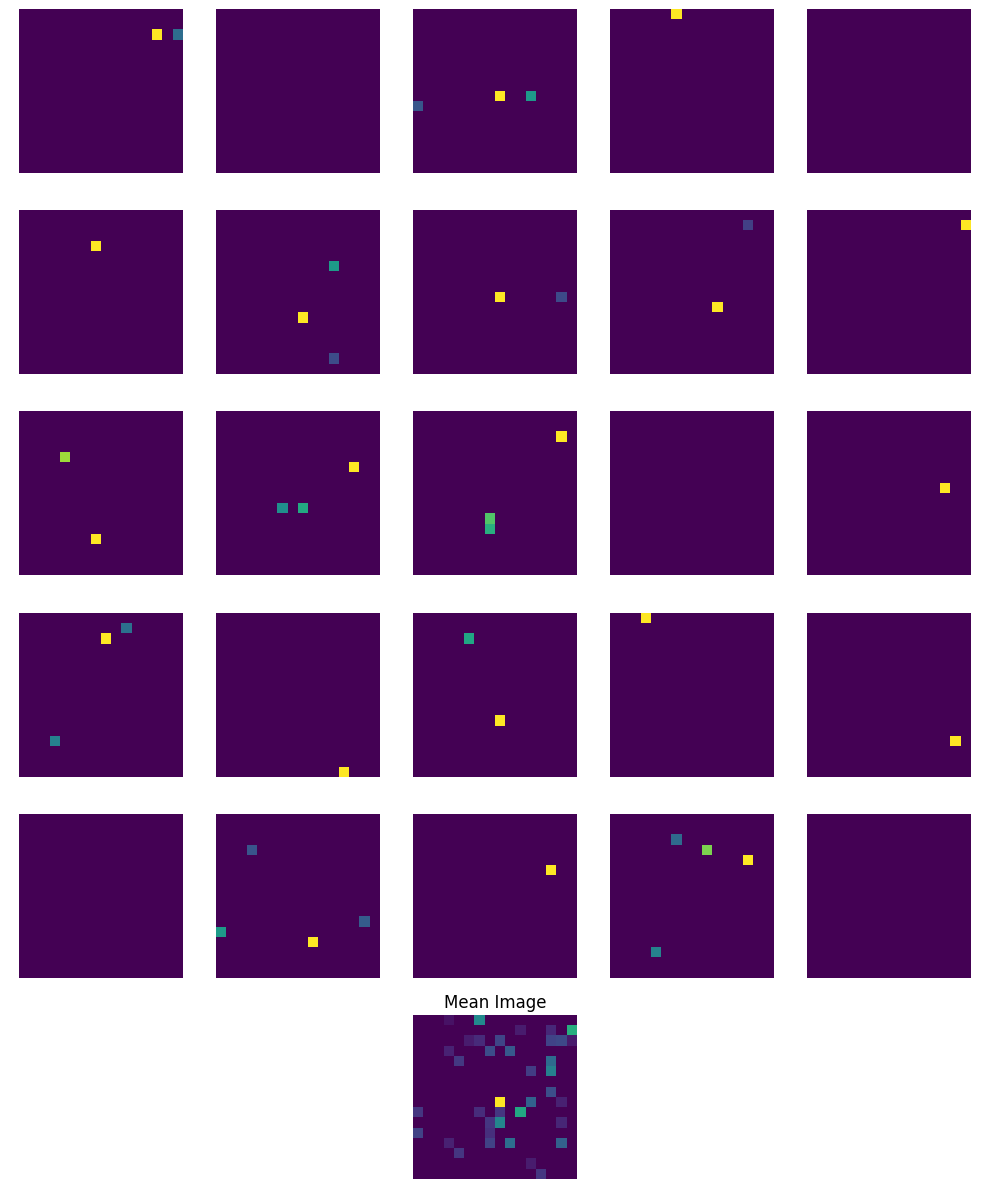

In [41]:
def plot_many_samples_with_mean(data, Nsamples, num_rows=4, num_cols=4):
    total_images = num_rows * num_cols
    fig, ax = plt.subplots(num_rows + 1, num_cols, figsize=(num_cols * 2, (num_rows + 1) * 2))
    
    # nums = np.random.randint(0, Nsamples, size=(total_images,))
    # nums = np.linspace(0, total_images, 1)
    nums = np.arange(0, Nsamples)
    
    selected_images = []
    
    for i in range(num_rows):
        for j in range(num_cols):
            sample_idx = nums[i * num_cols + j]
            selected_image = data[sample_idx]
            selected_images.append(selected_image)
            ax[i, j].imshow(selected_image, cmap='viridis')
            ax[i, j].axis('off') 

    mean_image = np.mean(np.array(selected_images), axis=0)
    
    for j in range(num_cols):
        if j == num_cols // 2:
            ax[num_rows, j].imshow(mean_image, cmap='viridis')
            ax[num_rows, j].set_title("Mean Image", fontsize=12)
            ax[num_rows, j].axis('off')
        else:
            ax[num_rows, j].axis('off')
    
    fig.tight_layout()
    plt.show()

plot_many_samples_with_mean(ftest['X'], Nsamples=100, num_rows=5, num_cols=5)

In [20]:
ftest.close()